## Marketing Analytics Project
### Meetup.com Recommendation Systems
### Implicit Recommendation using Matrix Factorization using ALS (RSVP)

In [66]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
import random
import implicit

In [67]:
## Set the pandas dataframes to display a fixed number of columns and rows
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

### Data loading and preprocessing

In [68]:
## load the RSVP, Member and Events data 
rsvp = pd.read_csv('rsvps_all_new.csv')
members = pd.read_csv('members_new.csv',encoding='latin-1')
events = pd.read_csv('events_all_new.csv',encoding='latin-1')
groups = pd.read_csv('groups_austin.csv',encoding='latin-1')

In [69]:
members[members['id'] == 285533436]

,Unnamed: 0,Unnamed: 0.1,bio,city,country,group_id,hometown,id,joined,lang,lat,link,lon,name,other_services.facebook.identifier,other_services.flickr.identifier,other_services.linkedin.identifier,other_services.tumblr.identifier,other_services.twitter.identifier,photo.base_url,photo.highres_link,photo.photo_id,photo.photo_link,photo.thumb_link,photo.type,state,status,topics,visited
161508,1293,1293,NaN,Austin,us,14364582,NaN,285533436.0,1.568349e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.571974e+12
555350,829,829,NaN,Austin,us,18746019,NaN,285533436.0,1.564625e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12
902864,196,196,NaN,Austin,us,27072136,NaN,285533436.0,1.570405e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12
926458,961,961,NaN,Austin,us,27919387,NaN,285533436.0,1.569079e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12
951078,436,436,NaN,Austin,us,29004437,NaN,285533436.0,1.563543e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12
1016126,431,431,NaN,Austin,us,31158184,NaN,285533436.0,1.563563e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.571974e+12
1060173,42,42,NaN,Austin,us,32750265,NaN,285533436.0,1.570452e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.571867e+12
1170769,1390,1390,NaN,Austin,us,5051822,NaN,285533436.0,1.568260e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12
1192716,1001,1001,NaN,Austin,us,5947662,NaN,285533436.0,1.568491e+12,NaN,30.22,http://www.meetup.com/members/285533436,-97.75,Rachel Meade,NaN,NaN,NaN,NaN,NaN,https://secure.meetupstatic.com,https://secure.meetupstatic.com/photos/member/...,290878293.0,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,TX,active,[],1.570672e+12


In [70]:
groups[groups['id'] == 5947662].name

2141    PyLadies ATX
Name: name, dtype: object

#### Extract the required columns from the members dataframe

In [71]:
members = members[['group_id','id','name','joined','visited','topics']]
members['id'] = members['id'].astype(int)
members.head()

,group_id,id,name,joined,visited,topics
0,10023,179008112,...,1.492474e+12,1.492474e+12,[]
1,10023,4099389,*!* Tonya P. *!*,1.552514e+12,1.563500e+12,"[{'urlkey': 'ballroomdance', 'name': 'Ballroom..."
2,10023,7436497,** Marcia S. **,1.213335e+12,1.213853e+12,[]
3,10023,291431587,1Barret1WemTD,1.570863e+12,1.571010e+12,[]
4,10023,179208612,A,1.414026e+12,1.426009e+12,[]


#### Extract the required columns from the groups, events and rsvp dataframes

In [72]:
groups = groups[['category.id','description','id','members','name','rating','topics','urlname','who']]
events = events[['group.id','group.urlname','group.name','group.who','id']]
rsvp = rsvp[['event.id','group.id','member.member_id','response','rsvp_id']]

####  Calculate the number of events organized by each group

In [73]:
group_events = pd.DataFrame(events.groupby('group.id')["id"].nunique()).reset_index()
group_events = group_events.rename(columns = {'id':'count_of_events'})

#### Calculate the number of RSVPs for each member per group

In [74]:
rsvp_data = pd.DataFrame(rsvp.groupby(['group.id','member.member_id'])['rsvp_id'].count())
rsvp_data = rsvp_data.reset_index().rename(columns = {'rsvp_id':'count_of_rsvps'})

#### Merge the event count and RSVP information with the members dataframe

In [75]:
## Merge members and rsvp_data on member_id and group_id to get the RSVP information for each member and group.
members_rsvp = members.merge(rsvp_data, left_on =['group_id','id'],right_on=['group.id','member.member_id'], how='left')
members_rsvp = members_rsvp[['name','group_id',"id","count_of_rsvps"]]

## Merge the new dataset with group_events to get the number of events organized by each group
members_rsvp = members_rsvp.merge(group_events, left_on ='group_id', right_on ='group.id')

## Fill the NA values with 0 
members_rsvp["count_of_rsvps"].fillna(0, inplace=True)
members_rsvp["count_of_events"].fillna(0, inplace=True)

#### Calculate the number of events of a group that a member has RSVP'd for by the total number of events organized by the group

In [76]:
members_rsvp["rsvp_for_events"] = members_rsvp["count_of_rsvps"]/members_rsvp["count_of_events"]
members_rsvp = members_rsvp[["group_id","id","rsvp_for_events",'name']]
members_rsvp["rsvp_for_events"].fillna(0, inplace=True)

In [77]:
## Scale this ratio to be between 1 and 10
members_rsvp['rsvp_total'] = 1 + (members_rsvp['rsvp_for_events']-members_rsvp['rsvp_for_events'].min())*(10-1)/(members_rsvp['rsvp_for_events'].max()-members_rsvp['rsvp_for_events'].min())

In [78]:
## Select the required columns for recommendation
members_rsvp.columns = ['group_id', 'member_id', 'rsvp_for_events', 'member_name', 'rsvp_total']

In [79]:
members_rsvp.head()

,group_id,member_id,rsvp_for_events,member_name,rsvp_total
0,10023,179008112,0.0,...,1.0
1,10023,4099389,0.0,*!* Tonya P. *!*,1.0
2,10023,7436497,0.0,** Marcia S. **,1.0
3,10023,291431587,0.0,1Barret1WemTD,1.0
4,10023,179208612,0.0,A,1.0


In [80]:
## Create a copy of the main dataframe to pass it to the recommendation system
main_data = members_rsvp
data = main_data.dropna()
data = data.copy()

#### Convert the member and group IDs to category codes

In [81]:
## Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
data['member_id'] = data['member_id'].astype('category')
data['group_id'] = data['group_id'].astype('category')

## cat.codes creates a categorical id for the users and artists
data['user_id'] = data['member_id'].cat.codes
data['grp_id'] = data['group_id'].cat.codes

#### Convert the data to item-user and user-item matrices
The implicit library expects data as a item-user matrix so we create two matrices, one for fitting the model (item-user) and one for recommendations (user-item)

In [82]:
sparse_item_user = sparse.csr_matrix((data['rsvp_total'].astype(float), (data['grp_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['rsvp_total'].astype(float), (data['user_id'], data['grp_id'])))

In [83]:
## Display the sparsity
matrix_size = sparse_user_item.shape[0]*sparse_user_item.shape[1] # Number of possible interactions in the matrix
num_members = len(sparse_user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_members/matrix_size))
print("The sparsity of the dataset is",sparsity)

The sparsity of the dataset is 99.60808109549494


### Train-Test split

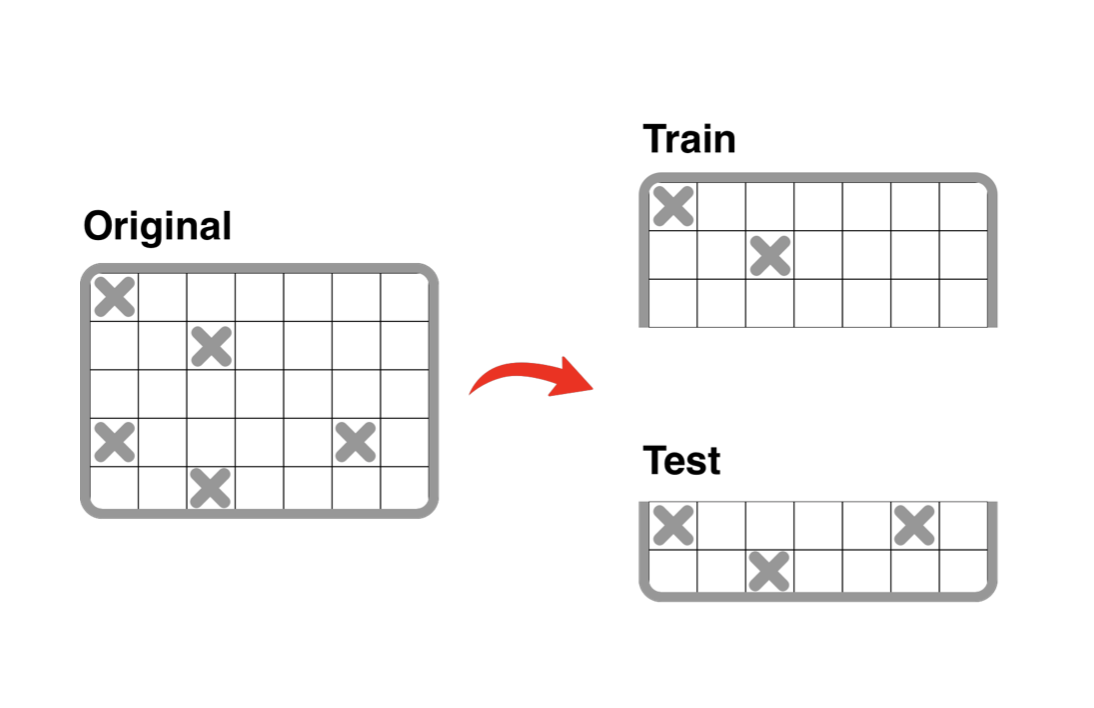

In [84]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    user_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    mask = {}
    #reference dictionary
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user columns that were altered

In [85]:
## 20% of the data has been masked for this exercise
product_train, product_test, product_users_altered = make_train(sparse_item_user, pct_test = 0.2)

### Alternating Least Squares

With the ALS model, we can use a grid search to find the optimal hyperparameters. This was implemented on PySpark.
The grid search gave us the best model with 20 latent factors and regularization = 0.1.

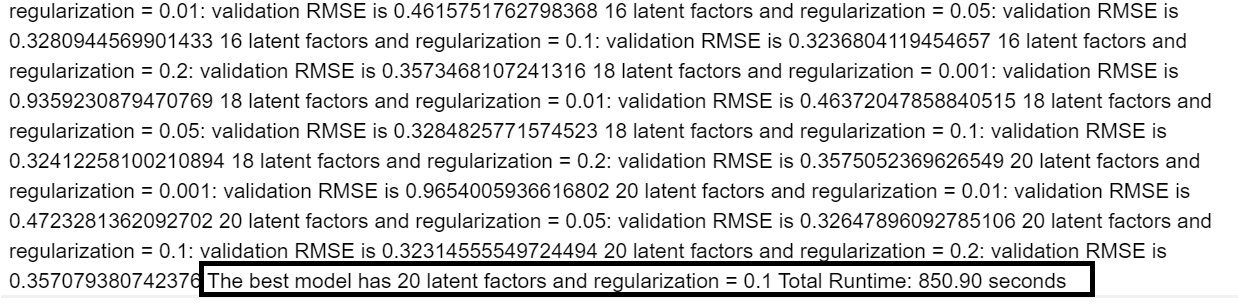

In [86]:
# Initialize the ALS model and fit it using the sparse item-user matrix
# Parameters that we have chosen
# 1. factors = 20 -- Latent factors for user and item vectors
# 2. iterations = 20 -- Number of iterations to use while fitting the data
# 3. regularization = 0.1 -- regularization constant to be used in the cost function

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=40)

# Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric 
# that we discussed earlier)

alpha_val = 15
data_conf = (product_train * alpha_val).astype('double')

# We have used an alpha_val of 15 after performing some iterations with different alpha values
#Fit the model
model.fit(data_conf)

100%|████████████████████████████████████████████████████████████████████████████████| 40.0/40 [00:19<00:00,  2.08it/s]


In [87]:
## Latent factor matrix
item_vecs = model.item_factors
user_vecs = model.user_factors

print('Shape of group vector matrix : ', item_vecs.shape)
print('Shape of member vector matrix : ', user_vecs.shape)

Shape of group vector matrix :  (816, 20)
Shape of member vector matrix :  (232987, 20)


#### Calculate the AUC scores to evaluate the recommender system

In [88]:
from sklearn import metrics
import matplotlib.pylab as plt
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_column = training_set[:,user].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [22]:
## AUC score for our recommender system
calc_mean_auc(product_train, product_users_altered,
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.761, 0.837)

#### Create a dictionary for the member and group IDs to be mapped to their respective category codes

In [89]:
mapping_group_dict = pd.Series(data['grp_id'].values,index=data.group_id).to_dict()
mapping_member_dict = pd.Series(data['user_id'].values,index=data.member_id).to_dict()

In [90]:
## Example User
## mapping_member_dict[109081562]

In [91]:
events.head()

,group.id,group.urlname,group.name,group.who,id
0,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbryzpbhb
1,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbryzqbfb
2,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybccbkb
3,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybcdbgb
4,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybcfbfb


In [92]:
events.columns = ['group_id', 'group.urlname', 'group.name', 'group.who' ,'id']

In [93]:
events.head()

,group_id,group.urlname,group.name,group.who,id
0,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbryzpbhb
1,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbryzqbfb
2,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybccbkb
3,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybcdbgb
4,8052752,BitcoinAustin,Austin Bitcoin Meetup: Satoshi Vision,Early adopters,vjnqbrybcfbfb


In [94]:
## Merge the data with the events dataframe to get the group names
data_final = pd.merge(data, events[['group.name','group_id']], on = 'group_id', how = 'inner')
data_final = data_final.drop_duplicates()

In [95]:
data_final.head()

,group_id,member_id,rsvp_for_events,member_name,rsvp_total,user_id,grp_id,group.name
0,10023,179008112,0.0,...,1.0,92258,0,Love-A-Bull Pit Bull Meetup
12,10023,4099389,0.0,*!* Tonya P. *!*,1.0,3776,0,Love-A-Bull Pit Bull Meetup
24,10023,7436497,0.0,** Marcia S. **,1.0,8434,0,Love-A-Bull Pit Bull Meetup
36,10023,291431587,0.0,1Barret1WemTD,1.0,230614,0,Love-A-Bull Pit Bull Meetup
48,10023,179208612,0.0,A,1.0,92331,0,Love-A-Bull Pit Bull Meetup


In [96]:
## Testing
## Pick a user from the Austin Data Science group
data_final[data_final['group.name'] == 'Data on Tap'].sort_values(by = "member_name", ascending = False)

,group_id,member_id,rsvp_for_events,member_name,rsvp_total,user_id,grp_id,group.name
36721093,31158184,282484228,0.0,vandhana kalyanaraman,1.0,223122,648,Data on Tap
36721076,31158184,7784331,0.0,todd,1.0,9141,648,Data on Tap
36721070,31158184,18142841,0.0,swaroop,1.0,32107,648,Data on Tap
36721055,31158184,9172391,0.0,spencebeecher,1.0,12853,648,Data on Tap
36721039,31158184,188796527,0.0,shashank kapoor,1.0,109032,648,Data on Tap
36720854,31158184,284069460,0.0,keerthi Thatipally,1.0,224941,648,Data on Tap
36720848,31158184,284970529,0.0,karan palsani,1.0,225899,648,Data on Tap
36720846,31158184,215863630,0.0,karan,1.0,150932,648,Data on Tap
36720820,31158184,10745974,0.0,joe\t,1.0,17389,648,Data on Tap
36720816,31158184,183747513,0.0,jgrosek,1.0,97457,648,Data on Tap


In [97]:
## Find the 10 most similar groups to Austin Data Science
group_id = 329
n_similar = 10 # Getting the top ten similar items

print ("------------Actual group-------------------")
print (data_final[data_final['grp_id'] == group_id]['group.name'].head(1))
print ("------------Similar groups-------------------")

# Use implicit to get similar items.
similar = model.similar_items(group_id, 5)
# Print the names of our most similar groups
for group in similar:
    idx, score = group
    print (data_final['group.name'].loc[data_final.grp_id == idx].iloc[0])

------------Actual group-------------------
20876398    Austin Data Science
Name: group.name, dtype: object
------------Similar groups-------------------
Austin Data Science
Austin Deep Learning
Austin Big Data AI
Austin AI Developers Group
Healthcare Predictive Analytics


### Generating recommendations

In [98]:
def recommend_group(user_id, num_of_recs):
    # Use the implicit recommender.
    recommended = model.recommend(mapping_member_dict[user_id], sparse_user_item,N = num_of_recs,filter_already_liked_items = False)
    
    meetup_groups = []
    scores = []
    
    ## Get the member names from IDs
    for item in recommended:
        idx, score = item
        meetup_groups.append(data_final['group.name'].loc[data_final.grp_id == idx].iloc[0])
        scores.append(score)
    
    # Create a dataframe of member names and scores
    recommendations = pd.DataFrame({'groups': meetup_groups, 'score': scores})
    user_past_groups = members_rsvp[members_rsvp["member_id"] == user_id]
    user_past_groups = user_past_groups[user_past_groups["rsvp_total"] > 1]
    user_past_groups = user_past_groups.merge(groups, left_on = "group_id", right_on = "id", how="left")

    return recommendations, user_past_groups[["group_id","name","rsvp_total"]]

In [99]:
recommended_groups, past_groups = recommend_group(187481513, 10)

In [100]:
recommended_groups, past_groups = recommend_group(14136557, 10)

In [101]:
recommended_groups, past_groups = recommend_group(192867271, 10)

In [102]:
recommended_groups, past_groups = recommend_group(6192675, 10)

In [106]:
recommended_groups, past_groups = recommend_group(285533436, 10)

In [107]:
print("The following groups are recommended to the user:")
print(recommended_groups)

The following groups are recommended to the user:
                            groups     score
0              Austin Data Science  1.225418
1             Austin Deep Learning  1.074968
2         The Austin Python Meetup  0.994722
3               Austin Big Data AI  0.994088
4       Austin AI Developers Group  0.899631
5      Women in Data Science - ATX  0.852709
6                Austin Data Geeks  0.833679
7                      Data on Tap  0.754062
8                     PyLadies ATX  0.744719
9  Healthcare Predictive Analytics  0.728205


In [108]:
print("The user is already a part of the following groups:")
print(past_groups)

The user is already a part of the following groups:
   group_id                name  rsvp_total
0  14364582  Austin Big Data AI         5.5
1  31158184         Data on Tap         5.5
